# Task Solving with Code Generation, Execution and Debugging

In this notebook, we demonstrate how to use `AssistantAgent` and `UserProxyAgent` to write code and execute the code. Here `AssistantAgent` is an LLM-based agent that can write Python code (in a Python coding block) for a user to execute for a given task. `UserProxyAgent` is an agent which serves as a proxy for the human user to execute the code written by `AssistantAgent`, or automatically execute the code. Depending on the setting of `human_input_mode` and `max_consecutive_auto_reply`, the `UserProxyAgent` either solicits feedback from the human user or returns auto-feedback based on the result of code execution (success or failure and corresponding outputs) to `AssistantAgent`. `AssistantAgent` will debug the code and suggest new code if the result contains error. The two agents keep communicating to each other until the task is done.

````{=mdx}
:::info Requirements
Install the following packages before running the code below:
```bash
pip install pyautogen matplotlib yfinance
```

For more information, please refer to the [installation guide](/docs/installation/).
:::
````

In [2]:
from IPython.display import Image, display

import autogen
from autogen.coding import LocalCommandLineCodeExecutor

config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={"tags": ["gpt-4o"]},  # comment out to get all
)
# When using a single openai endpoint, you can use the following:
# config_list = [{"model": "gpt-4o", "api_key": os.getenv("OPENAI_API_KEY")}]

## Example Task: Check Stock Price Change

In the example below, let's see how to use the agents in AutoGen to write a python script and execute the script. This process involves constructing a `AssistantAgent` to serve as the assistant, along with a `UserProxyAgent` that acts as a proxy for the human user. In this example demonstrated below, when constructing the `UserProxyAgent`,  we select the `human_input_mode` to "NEVER". This means that the `UserProxyAgent` will not solicit feedback from the human user. It stops replying when the limit defined by `max_consecutive_auto_reply` is reached, or when `is_termination_msg()` returns true for the received message.

In [3]:
# create an AssistantAgent named "assistant"
assistant = autogen.AssistantAgent(
    name="assistant",
    llm_config={
        "cache_seed": 41,  # seed for caching and reproducibility
        "config_list": config_list,  # a list of OpenAI API configurations
        "temperature": 0,  # temperature for sampling
    },  # configuration for autogen's enhanced inference API which is compatible with OpenAI API
)

# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config={
        # the executor to run the generated code
        "executor": LocalCommandLineCodeExecutor(work_dir="coding"),
    },
)
# the assistant receives a message from the user_proxy, which contains the task description
chat_res = user_proxy.initiate_chat(
    assistant,
    message="""What date is today? Compare the year-to-date gain for META and TESLA.""",
    summary_method="reflection_with_llm",
)

user_proxy (to assistant):

What date is today? Compare the year-to-date gain for META and TESLA.

--------------------------------------------------------------------------------
assistant (to user_proxy):

First, let's get the current date using Python. 

```python
# Python code
from datetime import date

# Get today's date
today = date.today()

# Print today's date
print("Today's date:", today)
```

Next, we need to fetch the stock prices for META (Facebook) and TESLA for the current year. We can use the `yfinance` library in Python to fetch this data. If `yfinance` is not installed, it can be installed using pip: `pip install yfinance`.

Here is the Python code to fetch the stock prices and calculate the year-to-date gain:

```python
# Python code
import yfinance as yf
from datetime import datetime

# Get the current year
current_year = datetime.now().year

# Download stock data for the current year
meta_data = yf.download('FB', start=f'{current_year}-01-01', end=today)
tesla_data 

The example above involves code execution. In AutoGen, code execution is triggered automatically by the `UserProxyAgent` when it detects an executable code block in a received message and no human user input is provided. 
Users have the option to specify a different working directory by setting the `work_dir` argument when constructing a new instance of the `LocalCommandLineCodeExecutor`.
For Docker-based or Jupyter kernel-based code execution, please refer to 
[Code Executors Tutorial](/docs/tutorial/code-executors) for more information.

#### Check chat results
The `initiate_chat` method returns a `ChatResult` object, which is a dataclass object storing information about the chat. Currently, it includes the following attributes:

- `chat_history`: a list of chat history.
- `summary`: a string of chat summary. A summary is only available if a summary_method is provided when initiating the chat.
- `cost`: a tuple of (total_cost, total_actual_cost), where total_cost is a dictionary of cost information, and total_actual_cost is a dictionary of information on the actual incurred cost with cache.
- `human_input`: a list of strings of human inputs solicited during the chat. (Note that since we are setting `human_input_mode` to `NEVER` in this notebook, this list is always empty.)

In [4]:
print("Chat history:", chat_res.chat_history)

print("Summary:", chat_res.summary)
print("Cost info:", chat_res.cost)

Chat history: [{'content': 'What date is today? Compare the year-to-date gain for META and TESLA.', 'role': 'assistant'}, {'content': 'First, let\'s get the current date using Python. \n\n```python\n# Python code\nfrom datetime import date\n\n# Get today\'s date\ntoday = date.today()\n\n# Print today\'s date\nprint("Today\'s date:", today)\n```\n\nNext, we need to fetch the stock prices for META (Facebook) and TESLA for the current year. We can use the `yfinance` library in Python to fetch this data. If `yfinance` is not installed, it can be installed using pip: `pip install yfinance`.\n\nHere is the Python code to fetch the stock prices and calculate the year-to-date gain:\n\n```python\n# Python code\nimport yfinance as yf\nfrom datetime import datetime\n\n# Get the current year\ncurrent_year = datetime.now().year\n\n# Download stock data for the current year\nmeta_data = yf.download(\'FB\', start=f\'{current_year}-01-01\', end=today)\ntesla_data = yf.download(\'TSLA\', start=f\'{curr

## Example Task: Plot Chart

In [5]:
# followup of the previous question
user_proxy.send(
    recipient=assistant,
    message="""Plot a chart of their stock price change YTD. Save the data to stock_price_ytd.csv, and save the plot to stock_price_ytd.png.""",
)

user_proxy (to assistant):

Plot a chart of their stock price change YTD. Save the data to stock_price_ytd.csv, and save the plot to stock_price_ytd.png.

--------------------------------------------------------------------------------
assistant (to user_proxy):

To plot a chart of the stock price change year-to-date (YTD) for META and TESLA, and to save the data and the plot, we can use the `matplotlib` and `pandas` libraries in Python. If these libraries are not installed, they can be installed using pip: `pip install matplotlib pandas`.

Here is the Python code to fetch the stock prices, plot the chart, and save the data and the plot:

```python
# Python code
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

# Get the current year and yesterday's date
current_year = datetime.now().year
yesterday = datetime.now() - timedelta(1)

# Download stock data for the current year
meta_data = yf.download('META', start=f'{current

Let's display the generated figure.

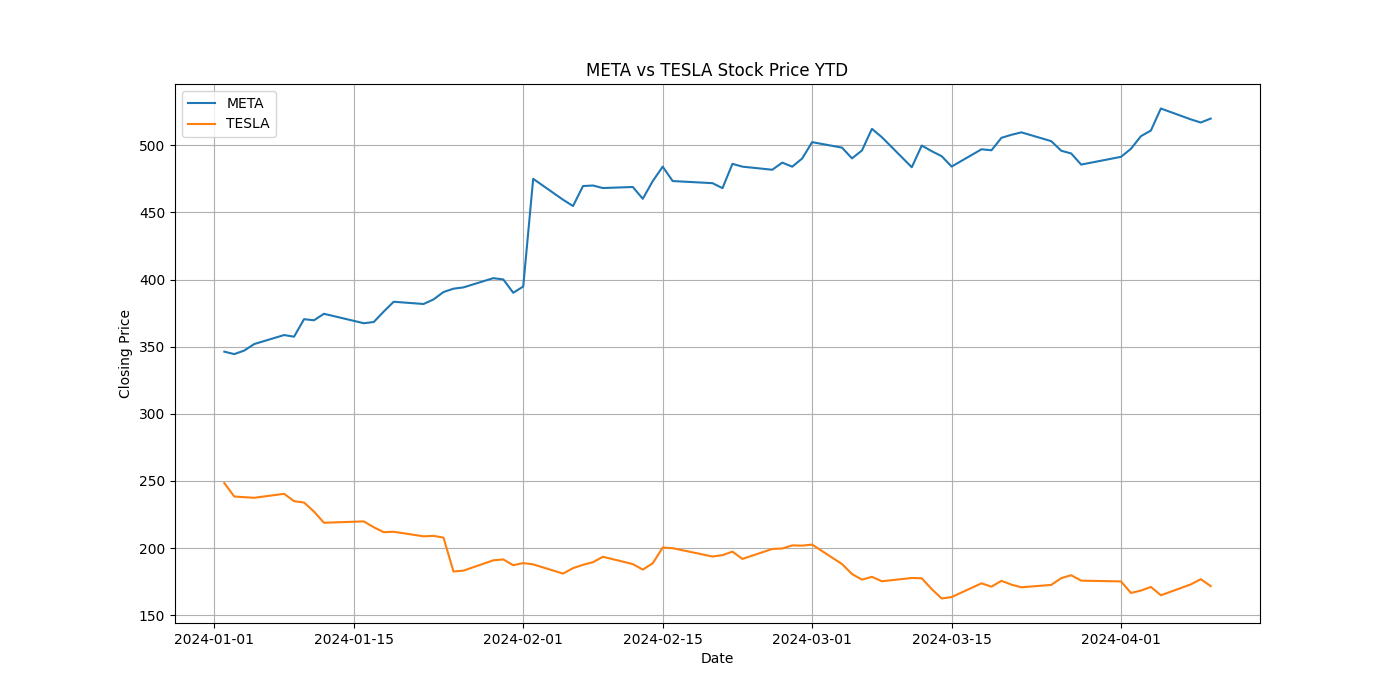

In [6]:
try:
    image = Image(filename="coding/stock_price_ytd.png")
    display(image)
except FileNotFoundError:
    print("Image not found. Please check the file name and modify if necessary.")

Let's display the raw data collected and saved from previous chat as well.

In [7]:
# Path to your CSV file
file_path = "coding/stock_price_ytd.csv"
try:
    with open(file_path, mode="r", encoding="utf-8") as file:
        # Read each line in the file
        for line in file:
            # Split the line into a list using the comma as a separator
            row = line.strip().split(",")
            # Print the list representing the current row
            print(row)
except FileNotFoundError:
    print("File not found. Please check the file name and modify if necessary.")

['Date', 'META', 'TESLA']
['2024-01-02', '346.2900085449219', '248.4199981689453']
['2024-01-03', '344.4700012207031', '238.4499969482422']
['2024-01-04', '347.1199951171875', '237.92999267578125']
['2024-01-05', '351.95001220703125', '237.49000549316406']
['2024-01-08', '358.6600036621094', '240.4499969482422']
['2024-01-09', '357.42999267578125', '234.9600067138672']
['2024-01-10', '370.4700012207031', '233.94000244140625']
['2024-01-11', '369.6700134277344', '227.22000122070312']
['2024-01-12', '374.489990234375', '218.88999938964844']
['2024-01-16', '367.4599914550781', '219.91000366210938']
['2024-01-17', '368.3699951171875', '215.5500030517578']
['2024-01-18', '376.1300048828125', '211.8800048828125']
['2024-01-19', '383.45001220703125', '212.19000244140625']
['2024-01-22', '381.7799987792969', '208.8000030517578']
['2024-01-23', '385.20001220703125', '209.13999938964844']
['2024-01-24', '390.70001220703125', '207.8300018310547']
['2024-01-25', '393.17999267578125', '182.63000488

## Example Task: Use User Defined Message Function to let Agents Analyze data Collected

Let's create a user defined message to let the agents analyze the raw data and write a blogpost. The function is supposed to take `sender`, `recipient` and `context` as inputs and outputs a string of message.

**kwargs from `initiate_chat` will be used as `context`. Take the following code as an example, the `context` includes a field `file_name` as provided in `initiate_chat`. In the user defined message function `my_message_generator`, we are reading data from the file specified by this filename.


In [11]:
def my_message_generator(sender, recipient, context):
    # your CSV file
    file_name = context.get("file_name")
    try:
        with open(file_name, mode="r", encoding="utf-8") as file:
            file_content = file.read()
    except FileNotFoundError:
        file_content = "No data found."
    return "Analyze the data and write a brief but engaging blog post. \n Data: \n" + file_content


# followup of the previous question
chat_res = user_proxy.initiate_chat(
    recipient=assistant,
    message=my_message_generator,
    file_name="coding/stock_price_ytd.csv",
    summary_method="reflection_with_llm",
    summary_args={"summary_prompt": "Return the blog post in Markdown format."},
)

user_proxy (to assistant):

Analyze the data and write a brief but engaging blog post. 
 Data: 
Date,META,TESLA
2024-01-02,346.2900085449219,248.4199981689453
2024-01-03,344.4700012207031,238.4499969482422
2024-01-04,347.1199951171875,237.92999267578125
2024-01-05,351.95001220703125,237.49000549316406
2024-01-08,358.6600036621094,240.4499969482422
2024-01-09,357.42999267578125,234.9600067138672
2024-01-10,370.4700012207031,233.94000244140625
2024-01-11,369.6700134277344,227.22000122070312
2024-01-12,374.489990234375,218.88999938964844
2024-01-16,367.4599914550781,219.91000366210938
2024-01-17,368.3699951171875,215.5500030517578
2024-01-18,376.1300048828125,211.8800048828125
2024-01-19,383.45001220703125,212.19000244140625
2024-01-22,381.7799987792969,208.8000030517578
2024-01-23,385.20001220703125,209.13999938964844
2024-01-24,390.70001220703125,207.8300018310547
2024-01-25,393.17999267578125,182.6300048828125
2024-01-26,394.1400146484375,183.25
2024-01-29,401.0199890136719,190.9299926

Let's check the summary of the chat

In [12]:
print(chat_res.summary)

---

# A Comparative Analysis of META and TESLA Stocks in Early 2024

In the first quarter of 2024, the stock market saw some interesting movements in the tech sector. Two companies that stood out during this period were META and TESLA. 

META, the social media giant, had an average stock price of 403.53 during this period. The highest it reached was 519.83, while the lowest was 344.47. The standard deviation, a measure of how spread out the prices were, was 100.72.

On the other hand, TESLA, the electric vehicle and clean energy company, had an average stock price of 219.54. The stock reached a high of 248.42 and a low of 171.76. The standard deviation for TESLA was 41.68.

These figures show that both META and TESLA had their ups and downs during this period. However, the higher standard deviation for META indicates that its stock price fluctuated more compared to TESLA.

As we move further into 2024, it will be interesting to see how these trends evolve. Will META and TESLA continue

This is the blog post that the agents generated.

# A Comparative Analysis of META and TESLA Stocks in Early 2024

In the first quarter of 2024, the stock market saw some interesting movements in the tech sector. Two companies that stood out during this period were META and TESLA. 

META, the social media giant, had an average stock price of 403.53 during this period. The highest it reached was 519.83, while the lowest was 344.47. The standard deviation, a measure of how spread out the prices were, was 100.72.

On the other hand, TESLA, the electric vehicle and clean energy company, had an average stock price of 219.54. The stock reached a high of 248.42 and a low of 171.76. The standard deviation for TESLA was 41.68.

These figures show that both META and TESLA had their ups and downs during this period. However, the higher standard deviation for META indicates that its stock price fluctuated more compared to TESLA.

As we move further into 2024, it will be interesting to see how these trends evolve. Will META and TESLA continue on their current trajectories, or will we see a shift in the market dynamics? Only time will tell.

Let's check how much the above chat cost

In [10]:
print(chat_res.cost)

({'total_cost': 0.84249, 'gpt-4-0613': {'cost': 0.84249, 'prompt_tokens': 22513, 'completion_tokens': 2785, 'total_tokens': 25298}}, {'total_cost': 0.84249, 'gpt-4-0613': {'cost': 0.84249, 'prompt_tokens': 22513, 'completion_tokens': 2785, 'total_tokens': 25298}})
